In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

Attribute Information:

FullDate: Date in format yyyy-mm-dd  hh:mm:ss

ElecPrice: Prices of electricity charged in Kw per hour

Gas Price: power generated was done via a gas power plant, gas price is the price of gas at time-T

SysLoad: Total Load on system or Power consumed at time-T

Tmax: maximum temperature at time-T

In [ ]:
d = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')
d.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB


In [ ]:
d.isna().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [ ]:
d['FullDate'] = pd.to_datetime(d['FullDate'])
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


In [ ]:
#set date as index
d.set_index('FullDate',inplace=True)

In [ ]:
d.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [ ]:
data_daily = d.resample('D').ffill()

In [ ]:
data_daily

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,15.8,1688.21500,3.6900,23.710
2010-09-02,15.4,1733.12000,3.6900,29.190
2010-09-03,18.3,1637.17500,4.4500,20.855
2010-09-04,13.7,1658.05000,3.3900,22.875
2010-09-05,14.9,1536.18500,4.4500,18.920
...,...,...,...,...
2021-02-24,22.4,270.29710,5.6000,29.360
2021-02-25,21.6,621.66545,5.4377,39.210
2021-02-26,22.8,1022.37690,5.4242,76.320


In [ ]:
data_daily.isna().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

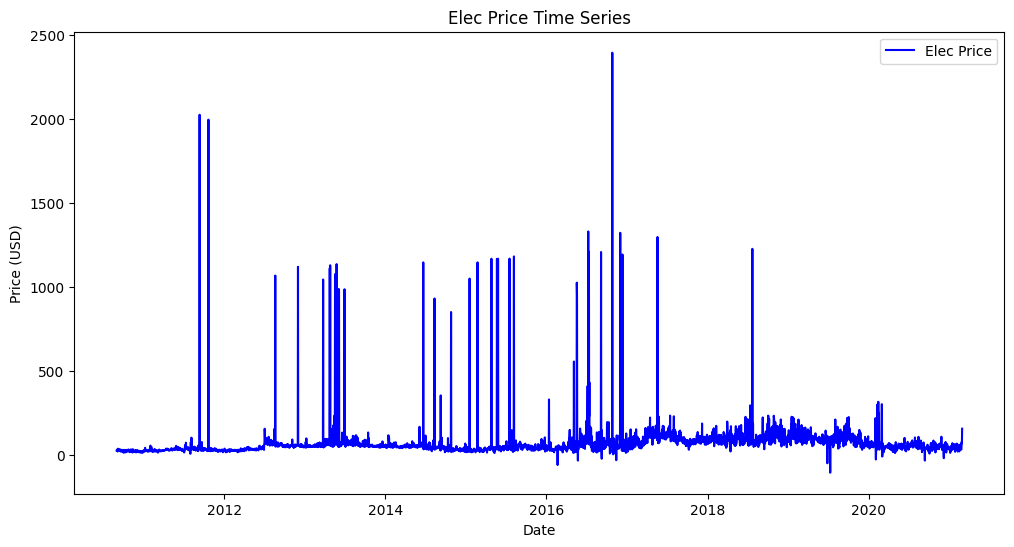

In [ ]:
#plot the bitcoin prices over time
plt.figure(figsize=(12,6))
plt.plot(data_daily.index,data_daily['ElecPrice'],label='Elec Price',color='b')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Elec Price Time Series')
plt.legend()
plt.show()

In [ ]:
x = d.drop(columns=['Tmax','ElecPrice'])
x.head()

,SysLoad,GasPrice
FullDate,,
2010-09-01 00:00:00,1688.215,3.69
2010-09-01 01:00:00,1669.195,3.69
2010-09-01 02:00:00,1491.980,3.69
2010-09-01 03:00:00,1330.760,3.69
2010-09-01 04:00:00,1247.940,3.69


In [ ]:
x_daily = x.resample('D').ffill()

In [ ]:
x_daily

,SysLoad,GasPrice
FullDate,,
2010-09-01,1688.21500,3.6900
2010-09-02,1733.12000,3.6900
2010-09-03,1637.17500,4.4500
2010-09-04,1658.05000,3.3900
2010-09-05,1536.18500,4.4500
...,...,...
2021-02-24,270.29710,5.6000
2021-02-25,621.66545,5.4377
2021-02-26,1022.37690,5.4242


In [ ]:
#Decompose the time seriers into trend, seasonality, and residuals
decomposition = seasonal_decompose(x_daily['GasPrice'],model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
#check stationarity using augmented dickey-ruller test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(time_series):
    results = adfuller(time_series)
    print("ADF statistic:",results[0])
    print("p-value:",results[1])
    print("critical values:")
    for key,value in results[4].items():
        print(f"{key}:{value}")

In [ ]:
#perform differencing to make the time series stationary
x_daily['Price_diff'] = x_daily['GasPrice'] - x_daily['GasPrice'].shift(1)
x_daily.dropna(inplace=True)

#check stationarity of the diferenced series
check_stationarity(x_daily['Price_diff'])

ADF statistic: -16.50097474309306
p-value: 2.148787818351714e-29
critical values:
1%:-3.432069767950114
5%:-2.8622998989518944
10%:-2.567174504136441


In [ ]:
#Decompose the time seriers into trend, seasonality, and residuals
decomposition = seasonal_decompose(x_daily['SysLoad'],model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
#check stationarity using augmented dickey-ruller test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(time_series):
    results = adfuller(time_series)
    print("ADF statistic:",results[0])
    print("p-value:",results[1])
    print("critical values:")
    for key,value in results[4].items():
        print(f"{key}:{value}")

In [ ]:
#perform differencing to make the time series stationary
x_daily['Price_diff'] = x_daily['SysLoad'] - x_daily['SysLoad'].shift(1)
x_daily.dropna(inplace=True)

#check stationarity of the diferenced series
check_stationarity(x_daily['Price_diff'])

ADF statistic: -18.14515996167827
p-value: 2.4846205108258974e-30
critical values:
1%:-3.4320715789803384
5%:-2.862300698944695
10%:-2.5671749300226385


In [ ]:
y = d.drop(columns=['Tmax','SysLoad'])
y.head()

,GasPrice,ElecPrice
FullDate,,
2010-09-01 00:00:00,3.69,23.710
2010-09-01 01:00:00,3.69,22.635
2010-09-01 02:00:00,3.69,22.565
2010-09-01 03:00:00,3.69,18.910
2010-09-01 04:00:00,3.69,18.030


In [ ]:
y_daily = y.resample('D').ffill()
y_daily

,GasPrice,ElecPrice
FullDate,,
2010-09-01,3.6900,23.710
2010-09-02,3.6900,29.190
2010-09-03,4.4500,20.855
2010-09-04,3.3900,22.875
2010-09-05,4.4500,18.920
...,...,...
2021-02-24,5.6000,29.360
2021-02-25,5.4377,39.210
2021-02-26,5.4242,76.320


In [ ]:
#Decompose the time seriers into trend, seasonality, and residuals
decomposition = seasonal_decompose(y_daily['ElecPrice'],model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
#check stationarity using augmented dickey-ruller test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(time_series):
    results = adfuller(time_series)
    print("ADF statistic:",results[0])
    print("p-value:",results[1])
    print("critical values:")
    for key,value in results[4].items():
        print(f"{key}:{value}")

In [ ]:
#perform differencing to make the time series stationary
y_daily['Price_diff'] = y_daily['ElecPrice'] - y_daily['ElecPrice'].shift(1)
y_daily.dropna(inplace=True)

#check stationarity of the diferenced series
check_stationarity(y_daily['Price_diff'])

ADF statistic: -19.40755246784684
p-value: 0.0
critical values:
1%:-3.4320711258652885
5%:-2.862300498788623
10%:-2.5671748234670364


In [ ]:
d = d.rename(columns={"FullDate":"ds","ElecPrice":"y"})
d.head()

,Tmax,SysLoad,GasPrice,y
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tmax      92016 non-null  float64
 1   SysLoad   92016 non-null  float64
 2   GasPrice  92016 non-null  float64
 3   y         92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB


In [ ]:
dd = d.resample('D').ffill()
dd

,Tmax,SysLoad,GasPrice,y
FullDate,,,,
2010-09-01,15.8,1688.21500,3.6900,23.710
2010-09-02,15.4,1733.12000,3.6900,29.190
2010-09-03,18.3,1637.17500,4.4500,20.855
2010-09-04,13.7,1658.05000,3.3900,22.875
2010-09-05,14.9,1536.18500,4.4500,18.920
...,...,...,...,...
2021-02-24,22.4,270.29710,5.6000,29.360
2021-02-25,21.6,621.66545,5.4377,39.210
2021-02-26,22.8,1022.37690,5.4242,76.320


In [ ]:
dd.reset_index(inplace=True)
dd.head()

,FullDate,Tmax,SysLoad,GasPrice,y
0,2010-09-01,15.8,1688.215,3.69,23.710
1,2010-09-02,15.4,1733.120,3.69,29.190
2,2010-09-03,18.3,1637.175,4.45,20.855
3,2010-09-04,13.7,1658.050,3.39,22.875
4,2010-09-05,14.9,1536.185,4.45,18.920


In [ ]:
dd = dd.rename(columns={"FullDate":"ds"})
dd.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,15.8,1688.215,3.69,23.710
1,2010-09-02,15.4,1733.120,3.69,29.190
2,2010-09-03,18.3,1637.175,4.45,20.855
3,2010-09-04,13.7,1658.050,3.39,22.875
4,2010-09-05,14.9,1536.185,4.45,18.920


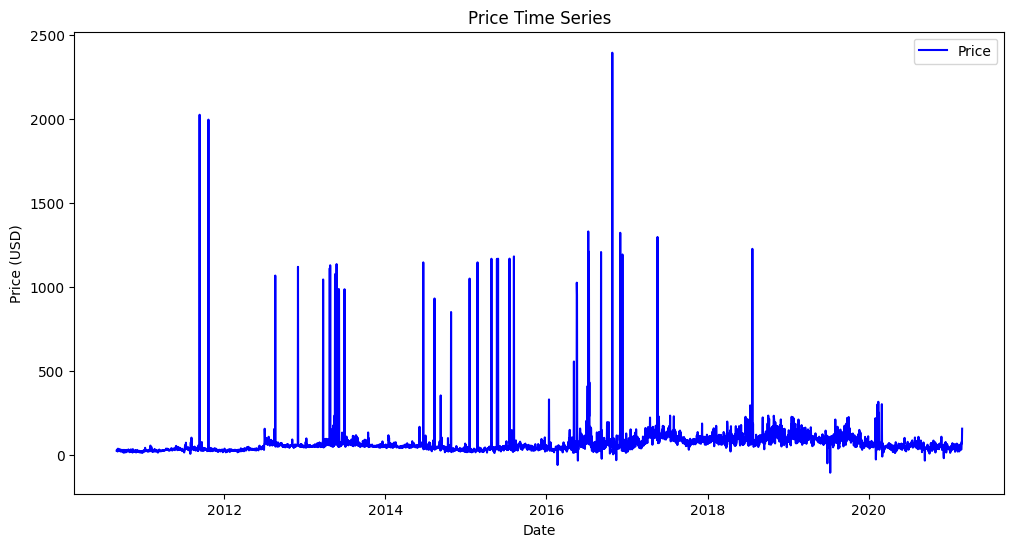

In [ ]:
#plot the bitcoin prices over time
plt.figure(figsize=(12,6))
plt.plot(dd.index,dd['y'],label='Price',color='b')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Price Time Series')
plt.legend()
plt.show()

In [ ]:
#Decompose the time seriers into trend, seasonality, and residuals
decomposition = seasonal_decompose(dd['y'],model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

Text(0.5, 1.0, 'Residual time series')

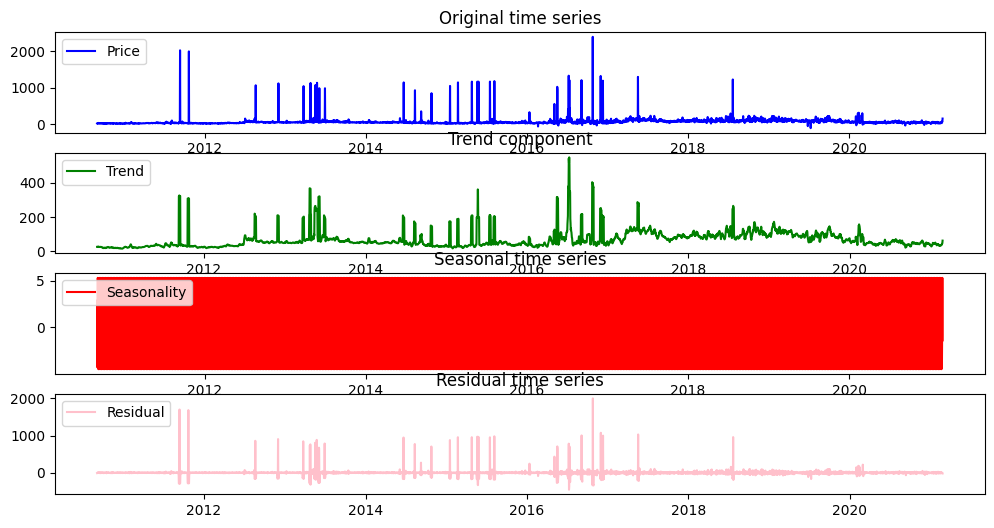

In [ ]:
#plot the decomposed components
plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(dd.index,dd['y'],label='Price',color='b')
plt.legend(loc='upper left')
plt.title('Original time series')
plt.subplot(4,1,2)
plt.plot(dd.index,trend,label='Trend',color='g')
plt.legend(loc='upper left')
plt.title('Trend component')
plt.subplot(4,1,3)
plt.plot(dd.index,seasonal,label='Seasonality',color='r')
plt.legend(loc='upper left')
plt.title('Seasonal time series')
plt.subplot(4,1,4)
plt.plot(dd.index,residual,label='Residual',color='pink')
plt.legend(loc='upper left')
plt.title('Residual time series')

In [ ]:
train_set = dd[0:2756]
train_set

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,15.8,1688.21500,3.6900,23.710
1,2010-09-02,15.4,1733.12000,3.6900,29.190
2,2010-09-03,18.3,1637.17500,4.4500,20.855
3,2010-09-04,13.7,1658.05000,3.3900,22.875
4,2010-09-05,14.9,1536.18500,4.4500,18.920
...,...,...,...,...,...
2751,2018-03-14,25.1,682.67470,8.8511,85.070
2752,2018-03-15,25.4,1022.15210,9.1928,134.790
2753,2018-03-16,27.0,840.83180,9.0400,104.845
2754,2018-03-17,30.2,662.77150,8.7100,84.325


In [ ]:
test_set = dd[2757:]
test_set

,ds,Tmax,SysLoad,GasPrice,y
2757,2018-03-20,22.5,853.26175,8.3995,84.845
2758,2018-03-21,23.8,-25.92870,8.4690,55.505
2759,2018-03-22,30.1,601.29820,8.4690,68.740
2760,2018-03-23,33.8,422.39965,8.2769,83.720
2761,2018-03-24,34.7,1073.53695,7.5090,111.765
...,...,...,...,...,...
3829,2021-02-24,22.4,270.29710,5.6000,29.360
3830,2021-02-25,21.6,621.66545,5.4377,39.210
3831,2021-02-26,22.8,1022.37690,5.4242,76.320
3832,2021-02-27,23.5,468.92800,5.4200,66.750


In [ ]:
from prophet import Prophet
model=Prophet()
model.fit(train_set)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzy1zn9k/fjenrv12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzy1zn9k/jbe5j96c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12433', 'data', 'file=/tmp/tmpuzy1zn9k/fjenrv12.json', 'init=/tmp/tmpuzy1zn9k/jbe5j96c.json', 'output', 'file=/tmp/tmpuzy1zn9k/prophet_modelsxraue8d/prophet_model-20230801143846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


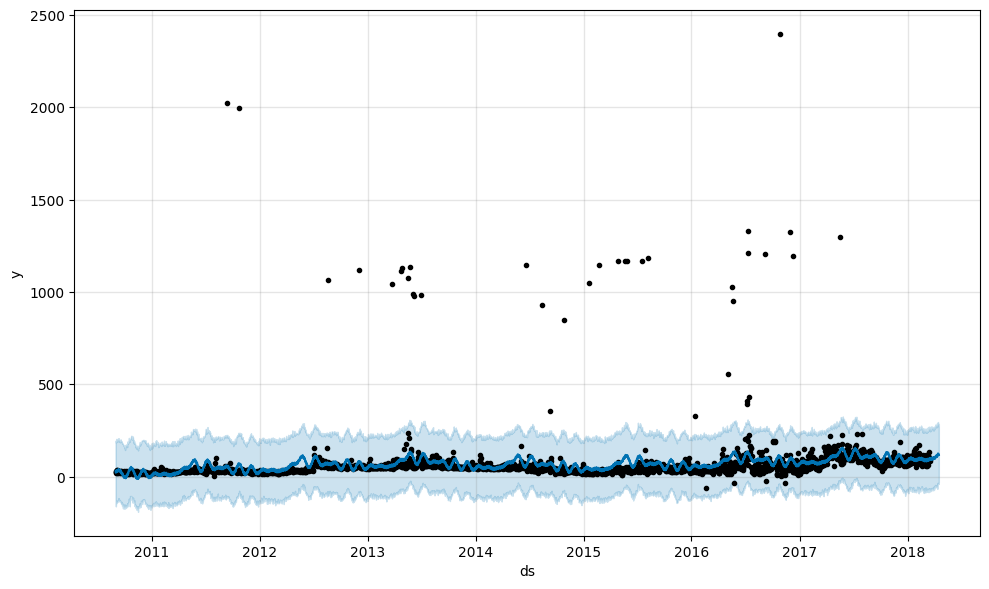

In [ ]:
#predict for the next 10 months
future = model.make_future_dataframe(periods=30,freq='D')
forecast = model.predict(future)
forecast.head()
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
model.plot(forecast)
plt.show()

In [ ]:
# Creating a Function for MAPE
import numpy as np

def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

In [ ]:
mape(test_set,forecast)

In [ ]:
d = d.rename(columns={"FullDate":"ds","SysLoad":"add1","Tmax":"add2","GasPrice":"add3","ElecPrice":"y"})
d.head()

In [ ]:
train_set = d.drop(columns='y')
train_set

In [ ]:
test_set = d['y']
test_set